In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

In [13]:
data = pd.read_csv('^NSEI-2.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,04-01-2010,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
1,05-01-2010,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2,06-01-2010,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
3,07-01-2010,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
4,08-01-2010,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0
...,...,...,...,...,...,...,...
2341,24-06-2019,11725.799810,11754.000000,11670.200200,11699.650390,11699.650390,277600.0
2342,25-06-2019,11681.000000,11814.400390,11651.000000,11796.450200,11796.450200,300500.0
2343,26-06-2019,11768.150390,11871.849610,11757.549810,11847.549810,11847.549810,327900.0
2344,27-06-2019,11860.849610,11911.150390,11821.049810,11841.549810,11841.549810,480200.0


In [14]:
data['% Volatility'] = 100*(data['High'] - data['Low'])/data['Open']
data

,Date,Open,High,Low,Close,Adj Close,Volume,% Volatility
0,04-01-2010,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0,1.371880
1,05-01-2010,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0,0.870739
2,06-01-2010,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0,0.962464
3,07-01-2010,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0,1.094320
4,08-01-2010,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0,0.798781
...,...,...,...,...,...,...,...,...
2341,24-06-2019,11725.799810,11754.000000,11670.200200,11699.650390,11699.650390,277600.0,0.714662
2342,25-06-2019,11681.000000,11814.400390,11651.000000,11796.450200,11796.450200,300500.0,1.398856
2343,26-06-2019,11768.150390,11871.849610,11757.549810,11847.549810,11847.549810,327900.0,0.971264
2344,27-06-2019,11860.849610,11911.150390,11821.049810,11841.549810,11841.549810,480200.0,0.759647


In [15]:
cleaned_data = data.dropna()
cleaned_data = cleaned_data.reset_index(drop=True)
cleaned_data


,Date,Open,High,Low,Close,Adj Close,Volume,% Volatility
0,04-01-2010,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0,1.371880
1,05-01-2010,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0,0.870739
2,06-01-2010,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0,0.962464
3,07-01-2010,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0,1.094320
4,08-01-2010,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0,0.798781
...,...,...,...,...,...,...,...,...
2316,24-06-2019,11725.799810,11754.000000,11670.200200,11699.650390,11699.650390,277600.0,0.714662
2317,25-06-2019,11681.000000,11814.400390,11651.000000,11796.450200,11796.450200,300500.0,1.398856
2318,26-06-2019,11768.150390,11871.849610,11757.549810,11847.549810,11847.549810,327900.0,0.971264
2319,27-06-2019,11860.849610,11911.150390,11821.049810,11841.549810,11841.549810,480200.0,0.759647


In [16]:
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=1000000):
        super(StockTradingEnv, self).__init__()

        self.data = data  # Stock price data
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.shares_held = 0
        self.current_step = 0
        self.max_steps = len(data)-5
        self.current_price = self.data.loc[self.current_step,'Open']
        # Define action space (buy/sell quantity)
        self.action_space = spaces.Discrete(101)  # Values from -50 to +50

        # Define observation space (price, balance, shares_held)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), high=np.array([np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
        )

    def reset(self ,*,seed = None, options = None):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 50
        self.no_steps = 0
        self.net_worth = self.balance
        return self._get_observation(), {'Balance' : self.balance , 'Shares Held' : self.shares_held , 'Net Worth' : self.net_worth}

    def step(self, action):
        action_value = action - 50  # Convert action to a range from -500 to +500
        self.current_price = self.data.loc[self.current_step,'Open']
        self.net_worth = self.balance + self.shares_held*self.current_price
        if action_value > 0:  # Buy action
            max_buy_amount = self.balance // self.current_price
            buy_amount = min(max_buy_amount, action_value)
            self.balance -= self.current_price * buy_amount
            self.shares_held += buy_amount

        elif action_value < 0:  # Sell action
            sell_amount = min(self.shares_held, -action_value)
            self.balance += self.current_price * sell_amount
            self.shares_held -= sell_amount

        self.current_step += 1
        self.no_steps += 1
        if self.current_step > self.max_steps:
            terminated = True
        else:
            terminated = False
        truncated = False
        reward = self._calculate_reward()
        info = {'Balance' : self.balance , 'Shares Held' : self.shares_held , 'Net Worth' : self.net_worth}
        return self._get_observation(), reward, terminated, truncated, info

    def _get_observation(self):
        observation = np.zeros(13)
        observation[0] = self.current_price
        volatility = 0
        for i in range(1,10):
            observation[i] = self.data.loc[self.current_step - i,'Close']
            volatility += self.data.loc[self.current_step - i, '% Volatility']
        volatility /= 9
        observation[10] = volatility
        observation[11] = self.balance
        observation[12] = self.shares_held
        observation = observation.astype(np.float32)
        return observation

    def _calculate_reward(self):
        reward = self.balance + self.shares_held * self.data.loc[self.current_step,'Close'] - self.net_worth
        return reward

    def render(self, mode="human"):
        # Implement visualization of the environment if desired
        pass

    

In [17]:
env = StockTradingEnv(cleaned_data)

In [18]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN,A2C,PPO
import torch

In [19]:
torch.cuda.is_available()

False

In [20]:
env = StockTradingEnv(cleaned_data)
#env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])

In [21]:
model = DQN('MlpPolicy', env, verbose=1)

Using cpu device


In [22]:
#model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=3000000)

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.971    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5730     |
|    time_elapsed     | 1        |
|    total_timesteps  | 9068     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 5612     |
|    time_elapsed     | 3        |
|    total_timesteps  | 18136    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.914    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 5996     |
|    time_elapsed     | 4        |
|    total_timesteps  | 27204    |
----------------------------------
----------------------------------
| rollout/          

In [23]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
tot_rew = 0
pos_reward = 0
neg_reward = 0
net_worth = []
shares_held = []
rewards = []
actions = []
for game in range(1): 
    while not done: 
        action = model.predict(obs)[0]
        obs, reward, done, info = env.step(action)
        print("Action:", action-50)
        actions.append(action-50)
        print("Info:", info)
        net_worth.append(info[0]["Net Worth"])
        shares_held.append(info[0]["Shares Held"])
        print("Reward:", reward)
        rewards.append(reward[0])
        print("Done:", done)
        print("----")
        tot_rew += reward
        if reward >= 0:
            pos_reward +=reward
        else:
            neg_reward += reward
print(info)
print(tot_rew)
print(pos_reward)
print(neg_reward)

Action: [32]
Info: [{'Balance': 832558.40624, 'Shares Held': 32, 'Net Worth': 1000000.0, 'TimeLimit.truncated': False}]
Reward: [968.]
Done: [False]
----
Action: [32]
Info: [{'Balance': 664660.8124800001, 'Shares Held': 64, 'Net Worth': 1000456.0, 'TimeLimit.truncated': False}]
Reward: [-2662.375]
Done: [False]
----
Action: [32]
Info: [{'Balance': 496310.40624000004, 'Shares Held': 96, 'Net Worth': 1001361.6249600002, 'TimeLimit.truncated': False}]
Reward: [-3422.4375]
Done: [False]
----
Action: [32]
Info: [{'Balance': 329723.2031040001, 'Shares Held': 128, 'Net Worth': 996072.0156480001, 'TimeLimit.truncated': False}]
Reward: [6982.375]
Done: [False]
----
Action: [32]
Info: [{'Balance': 162513.60934400008, 'Shares Held': 160, 'Net Worth': 998561.578144, 'TimeLimit.truncated': False}]
Reward: [9072.031]
Done: [False]
----
Action: [32]
Info: [{'Balance': 4697.1151940001, 'Shares Held': 190.0, 'Net Worth': 1004201.578144, 'TimeLimit.truncated': False}]
Reward: [8037.0557]
Done: [False]
-

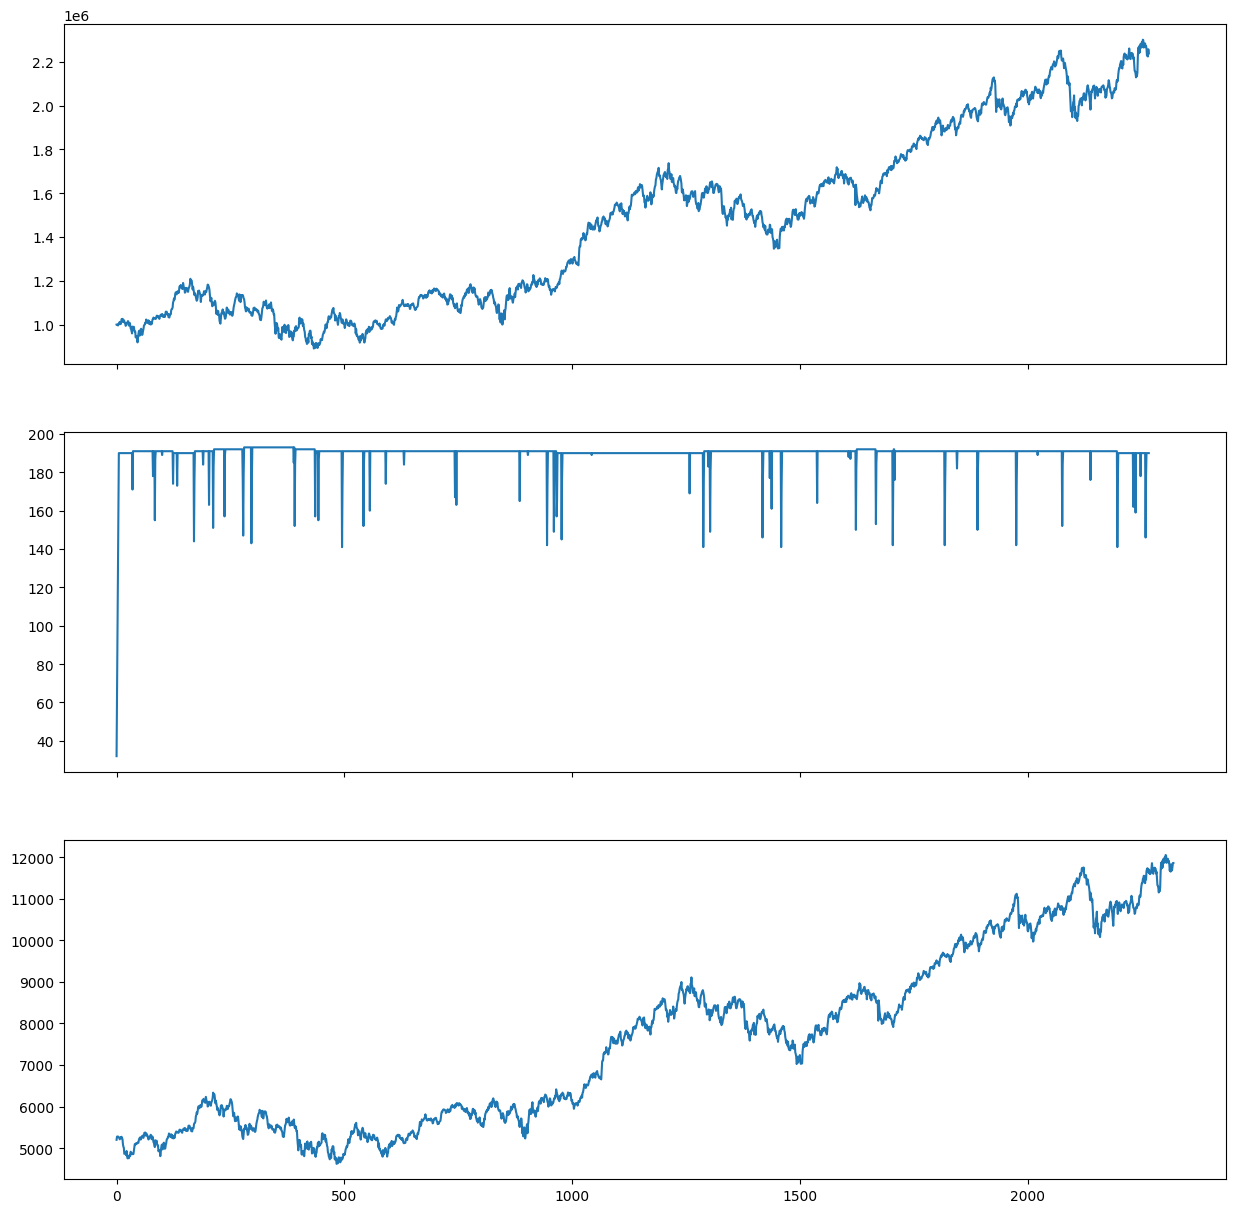

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15),sharex=True)
ax1.plot(net_worth)
ax2.plot(shares_held)
ax3.plot(cleaned_data['Open'])
plt.show()

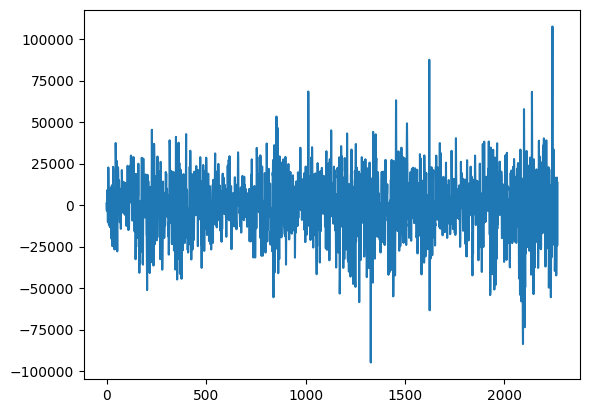

In [25]:
plt.plot(rewards)
plt.show()

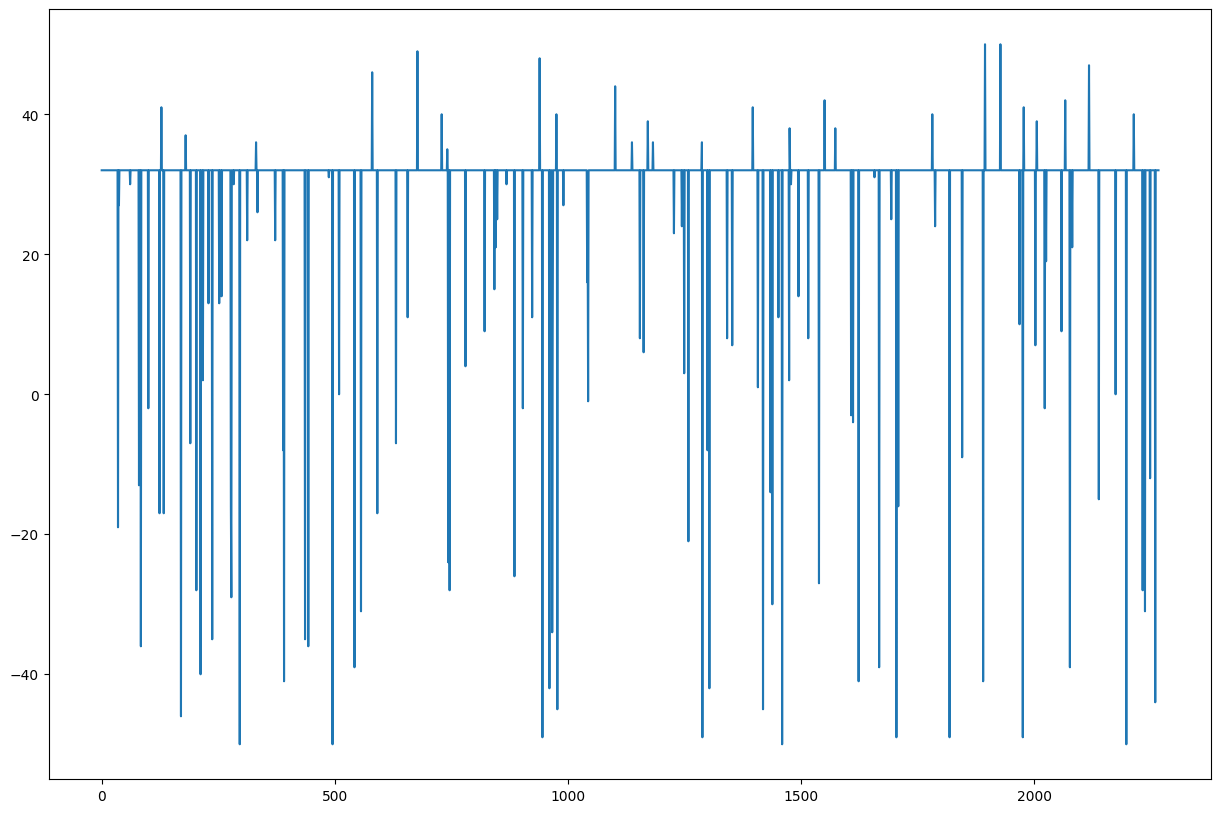

In [26]:
plt.figure(figsize=(15,10))
plt.plot(actions)
plt.show()

In [27]:
test_data = pd.read_csv("^NSEI-1.csv")

In [28]:
test_data['% Volatility'] = 100*(test_data['High'] - test_data['Low'])/test_data['Open']
cleaned_test_data = test_data.dropna()
cleaned_test_data = cleaned_test_data.reset_index(drop=True)

In [29]:
env = StockTradingEnv(cleaned_test_data)
env = DummyVecEnv([lambda: env])

In [30]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
tot_rew = 0
pos_reward = 0
neg_reward = 0
net_worth = []
shares_held = []
rewards = []
actions = []
for game in range(1): 
    while not done: 
        action = model.predict(obs)[0]
        obs, reward, done, info = env.step(action)
        print("Action:", action-50)
        actions.append(action-50)
        print("Info:", info)
        net_worth.append(info[0]["Net Worth"])
        shares_held.append(info[0]["Shares Held"])
        print("Reward:", reward)
        rewards.append(reward[0])
        print("Done:", done)
        print("----")
        tot_rew += reward
        if reward >= 0:
            pos_reward +=reward
        else:
            neg_reward += reward
print(info)
print(tot_rew)
print(pos_reward)
print(neg_reward)

Action: [32]
Info: [{'Balance': 648422.40608, 'Shares Held': 32, 'Net Worth': 1000000.0, 'TimeLimit.truncated': False}]
Reward: [534.40607]
Done: [False]
----
Action: [32]
Info: [{'Balance': 296587.21856, 'Shares Held': 64, 'Net Worth': 1000257.5936, 'TimeLimit.truncated': False}]
Reward: [-11344.]
Done: [False]
----
Action: [32]
Info: [{'Balance': 10584.628700000001, 'Shares Held': 90.0, 'Net Worth': 1000593.5936, 'TimeLimit.truncated': False}]
Reward: [-14350.43]
Done: [False]
----
Action: [32]
Info: [{'Balance': 10584.628700000001, 'Shares Held': 90.0, 'Net Worth': 989136.6116000001, 'TimeLimit.truncated': False}]
Reward: [-15120.]
Done: [False]
----
Action: [32]
Info: [{'Balance': 10584.628700000001, 'Shares Held': 90.0, 'Net Worth': 986652.6466999999, 'TimeLimit.truncated': False}]
Reward: [38610.]
Done: [False]
----
Action: [32]
Info: [{'Balance': 10584.628700000001, 'Shares Held': 90.0, 'Net Worth': 977796.6116000001, 'TimeLimit.truncated': False}]
Reward: [76806.03]
Done: [Fals

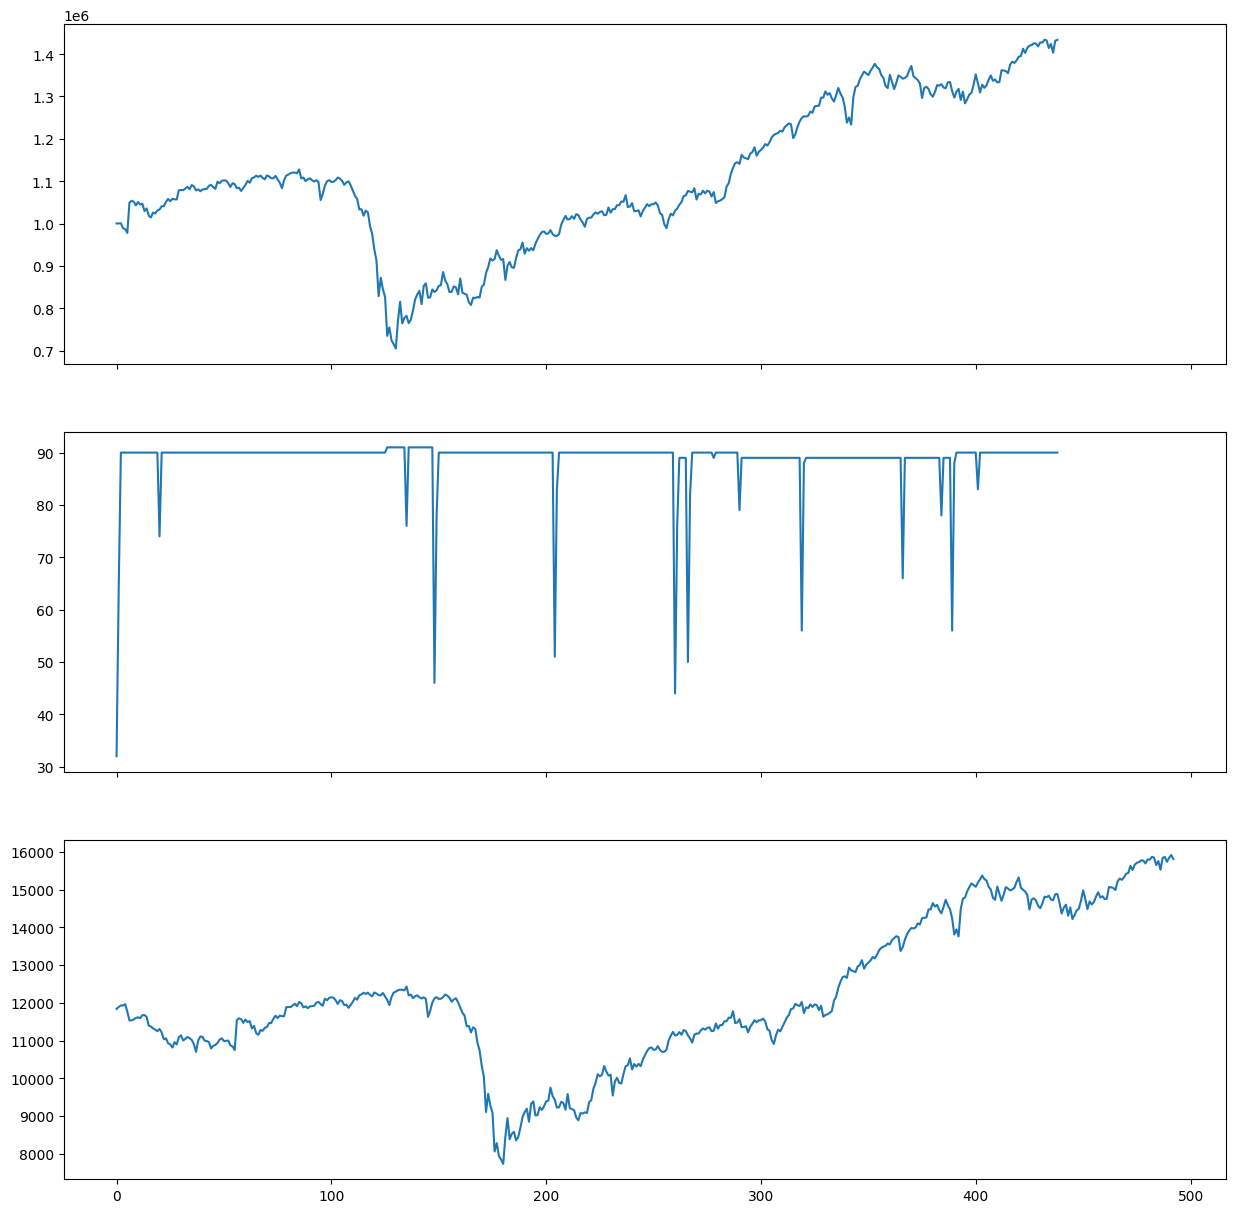

In [31]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15),sharex=True)
ax1.plot(net_worth)
ax2.plot(shares_held)
ax3.plot(cleaned_test_data['Open'])
plt.show()

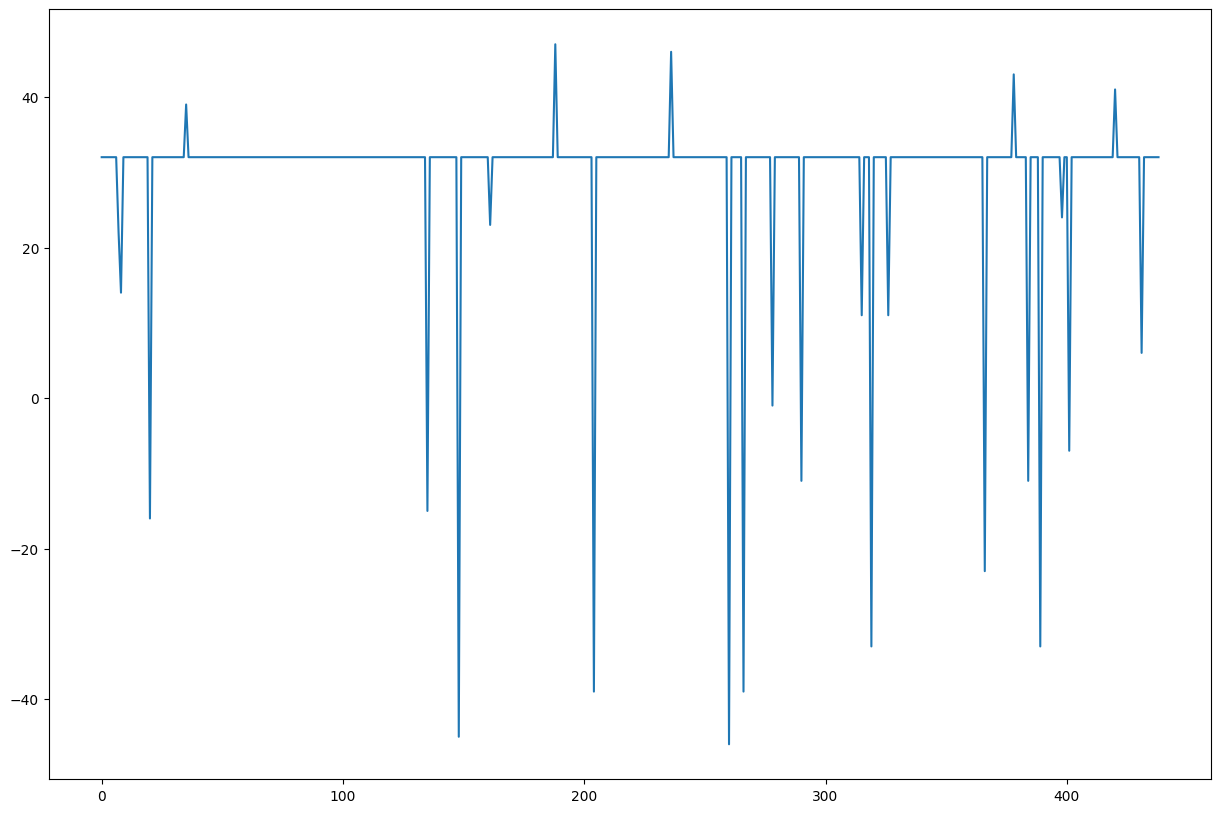

In [32]:
plt.figure(figsize=(15,10))
plt.plot(actions)
plt.show()

In [33]:
model.save("DQN_model")